In [9]:
import numpy as np
import cv2

# Add any python libraries here
import argparse
import cv2
from matplotlib import pyplot as plt

#Helper funcs
def cvt_for_plt(img):
    return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)



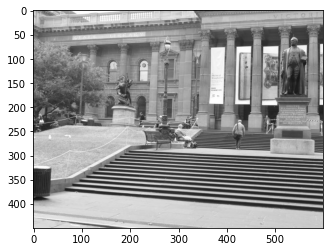

In [15]:
base_path = '../Data/Train/'
img_set = 'Set1/'
img_sequence = '3'
img1 = cv2.imread(base_path + img_set + img_sequence + '.jpg')
img1_gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
plt.imshow(cvt_for_plt(img1_gray))

3410


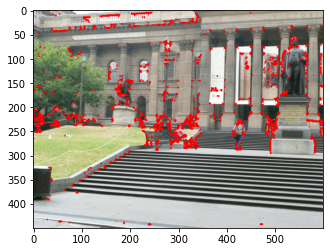

In [23]:
#Parameters
## corner Detection
ch_block_size = 2
ch_ksize = 3
ch_k = 0.04

cornersOfImg = cv2.cornerHarris(img1_gray,ch_block_size,ch_ksize,ch_k)

img_corners = img1
img_corners[cornersOfImg>0.01*cornersOfImg.max()] = [0,0,255]
plt.imshow(cvt_for_plt(img_corners))
print(np.sum(cornersOfImg>0.01*cornersOfImg.max()))